In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
from matplotlib.gridspec import GridSpec
from astropy.table import Table, vstack, Column, MaskedColumn
from astropy import units as u
from scipy.stats import kde
from scipy.stats import binned_statistic as b_s
from scipy.stats import binned_statistic_2d as bs2d
from astropy import units as un
from astropy import constants as con
from matplotlib.lines import Line2D

from astropy.cosmology import Planck15
from tqdm import trange
from scipy.stats import ks_2samp
from scipy import special

import os
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

plt.rc('path', simplify=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize='xx-large', facecolor='none', linewidth=0.7)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('lines', markersize=4, linewidth=1, markeredgewidth=0.2)
plt.rc('legend', numpoints=1, frameon=False, handletextpad=0.3, scatterpoints=1, handlelength=2, handleheight=0.1)
#plt.rc('savefig', facecolor='none', frameon='False')

params =   {'font.size' : 16,
            'xtick.major.size': 8,
            'ytick.major.size': 8,
            'xtick.minor.size': 3,
            'ytick.minor.size': 3,
            }
plt.rcParams.update(params) 

np.warnings.filterwarnings('ignore')

def legend_outside_plot(ax,location='top',ncol=3,pad=0, handles=None, labels=None):
    if handles==None:
        handles, labels = ax.get_legend_handles_labels()
    if location=='top':
        leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(0,1.02+pad,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=ncol)
    else:
        print("Location",location,"not implemented. Please code up")
    return leg


In [2]:
data = Table.read('cut1045match.fits', format = 'fits' )
#i think this is the i band match

In [3]:
data.rename_column('col1', 'RAdeg')  
data.rename_column('col2', 'DEdeg') 
data.rename_column('col3', 'Imag') 
data.rename_column('col4', 'S')  
data.rename_column('col5', 'zspec') 
data.rename_column('col6', 'N')  
data.rename_column('col7', 'zG')  
data.rename_column('col8', 'chi2G')  
data.rename_column('col9', 'LEll')  
data.rename_column('col10', 'LSbc') 
data.rename_column('col11', 'LIrr')
data.rename_column('col12', 'zGA') 
data.rename_column('col13', 'chi2GA') 
data.rename_column('col14', 'LAGNp') 
data.rename_column('col15', 'LELLp') 
data.rename_column('col16', 'LSbcp') 
data.rename_column('col17', 'LIrrp') 
data.rename_column('col18', 'F') 
data.rename_column('col19', 'EBV') 
data.rename_column('col20', 'LAGNerg') 
data.rename_column('col21', 'logF') 
data.rename_column('col22', 'I') 
data.rename_column('col23', 'index') 
data.rename_column('col24', 'LSbcerg') 
data.rename_column('col25', 'LEllerg') 
data.rename_column('col26', 'LIrrerg') 
data.rename_column('col27', 'Lg') 
data.rename_column('col28', 'LGlog') 
data.rename_column('col29', 'LSbcergp') 
data.rename_column('col30', 'LEllergp') 
data.rename_column('col31', 'LIrrergp') 
data.rename_column('col32', 'Lgp') 
data.rename_column('col33', 'LGlogp') 

In [4]:
AV = [i*3.2 for i in data['EBV']]

AV = MaskedColumn(name = "AV", data = AV  , dtype=np.float64) 
data.add_column(AV)
#data.replace_column('AV',AV)

In [5]:
data

RAdeg,DEdeg,Imag,S,zspec,N,zG,chi2G,LEll,LSbc,LIrr,zGA,chi2GA,LAGNp,LELLp,LSbcp,LIrrp,F,EBV,LAGNerg,logF,I,index,LSbcerg,LEllerg,LIrrerg,Lg,LGlog,LSbcergp,LEllergp,LIrrergp,Lgp,LGlogp,RA,DEC,Z,IMAG,TYPE,LBOL,Separation,AV
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,
float64,float64,float32,float32,float32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64
217.78458,32.41383,21.2,0.03,-99.99,14/0,1.23,16.28,0.0,1.689,0.451,1.08,4.07,1.636,-0.461,1.398,0.449,15.97,0.79,45.216,1.203304916138483,18.63,4736.0,45.269,43.58,44.031,1.9652033963258156e+45,45.29340750602471,44.978,43.119,44.028999999999996,1.0706625299004722e+45,45.02965260388741,217.78451,32.413882,1.12,21.2,2,45.57842855366834,0.2833748166945669,2.528000068664551
218.15931,32.47416,22.56,0.07,-99.99,14/1,3.0,12.47,0.0,2.505,0.115,0.83,1.44,1.709,0.063,0.0,-0.896,39.17,0.79,45.289,1.592953571547866,19.01,7624.0,46.085,43.58,43.695,1.2211405025544184e+46,46.08676563607718,43.58,43.643,42.684,4.878474956418022e+43,43.68828407988713,218.15906,32.474203,1.51,22.63,2,46.01604854096319,0.7748897787312795,2.528000068664551
216.49839,32.47729,21.11,0.71,1.75,12/0,1.89,13.28,0.0,1.505,1.641,1.71,1.59,1.981,0.0,1.541,-1.838,30.33,0.1,45.561,1.4818724103106635,19.03,7812.0,45.085,43.58,45.221,2.8795986510165264e+45,45.45933196144145,45.120999999999995,43.58,41.742,1.3218477116258411e+45,45.12118142352311,216.49852,32.477431,1.7523000240325928,21.19,1,45.9181019295332,0.6430629455451671,0.3200000047683716
217.18755,32.47921,21.4,0.06,-99.99,14/0,2.88,29.5,0.0,2.615,1.724,0.85,1.22,1.898,0.546,0.0,0.192,105.58,0.79,45.478,2.0235816576649395,19.05,7936.0,46.195,43.58,45.303999999999995,1.7681234950943865e+46,46.247512595159506,43.58,44.126,43.772,1.928157150721907e+44,44.285142427341704,217.18746,32.47913,1.36,21.47,2,46.09121468187645,0.39705033687873637,2.528000068664551
216.41592,32.48202,19.85,0.22,1.03,12/0,1.89,59.95,0.0,1.488,1.774,0.92,5.42,1.818,1.27,0.0,0.674,41.26,0.0,45.397999999999996,1.6155292236371328,19.06,8101.0,45.068,43.58,45.354,3.4289351612408386e+45,45.53515927298851,43.58,44.85,44.254,8.87419147067392e+44,44.948128794874115,216.41587,32.482171,1.0261499881744385,19.87,1,45.559549092320594,0.5644081418964183,0.0
216.53477,32.49056,21.67,0.04,-99.99,13/0,1.96,42.63,0.0,2.441,0.0,1.33,3.26,2.763,1.235,0.0,0.807,49.32,0.79,46.342999999999996,1.693023067923694,19.12,8591.0,46.021,43.58,43.58,1.0495424286523242e+46,46.021,43.58,44.815,44.387,8.969116344843445e+44,44.95274965759677,216.53468,32.490555,1.27,21.71,2,46.23013123842353,0.2738796552139101,2.528000068664551
217.3635,32.5104,20.82,0.82,-99.99,13/0,0.97,46.32,0.0,1.46,0.0,0.69,9.63,1.434,0.592,0.0,-0.134,18.16,0.63,45.013999999999996,1.2591158441850663,19.21,9648.0,45.04,43.58,43.58,1.0964781961431829e+45,45.04,43.58,44.172,43.446,1.7651900264107293e+44,44.24679146495291,217.3635,32.510467,0.96,20.86,2,45.52128313039411,0.2411999999919059,2.015999984741211
216.49127,32.51537,21.79,0.03,-99.99,13/0,2.73,57.72,0.0,2.801,0.81,0.94,1.74,2.435,0.278,0.0,0.369,129.64,1.0,46.015,2.1127390223601723,19.24,9923.0,46.381,43.58,44.39,2.4289098891637854e+46,46.38541140308638,43.58,43.858,43.949,1.610308597040839e+44,44.20690911152829,216.49116,32.515414,1.59,22.12,2,46.604018030433835,0.3695903510840094,3.2


In [6]:
602/3647

0.16506717850287908

Text(0, 0.5, '$L_{Bol}$')

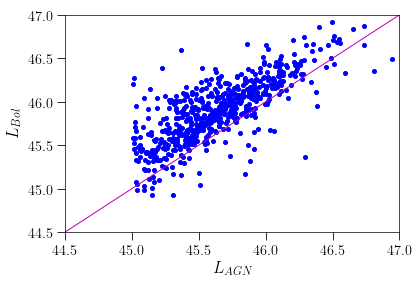

In [7]:
x = [43, 47]
y = [43,47]
plt.scatter(data['LAGNerg'],data['LBOL'], c = 'b')
plt.plot(x,y, c = 'm')
plt.xlim(44.5,47)
plt.ylim(44.5,47)
plt.xlabel(r'$L_{AGN}$')
plt.ylabel(r'$L_{Bol}$')

Text(0, 0.5, '$Z_{Hickox}$')

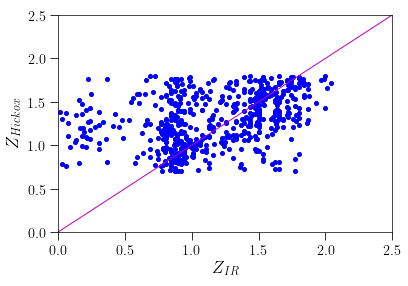

In [8]:
x = [0, 3]
y = [0,3]
plt.scatter(data['zGA'],data['Z'], c = 'b')
plt.plot(x,y, c='m')
plt.xlim(0,2.5)
plt.ylim(0,2.5)
plt.xlabel(r'$Z_{IR}$')
plt.ylabel(r'$Z_{Hickox}$')



(0.01, 0.5)

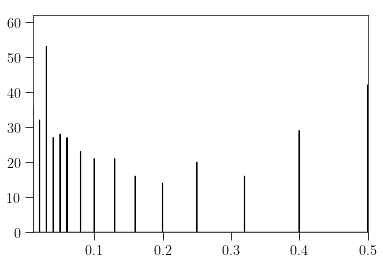

In [9]:
plt.hist(data['EBV'], bins=10000, histtype='step', color='black', density=False, lw=1)
plt.xlim(0.01,0.5)



In [10]:

type1 = data[data['TYPE']==1]
type2 = data[data['TYPE']==2]


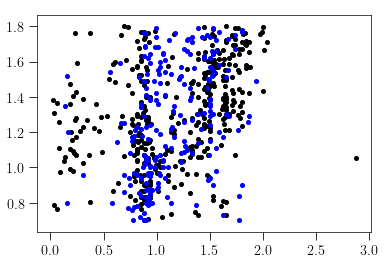

In [11]:
plt.scatter(type1['zGA'],type1['Z'], color = 'black')
plt.scatter(type2['zGA'],type2['Z'], color = 'blue')

[]

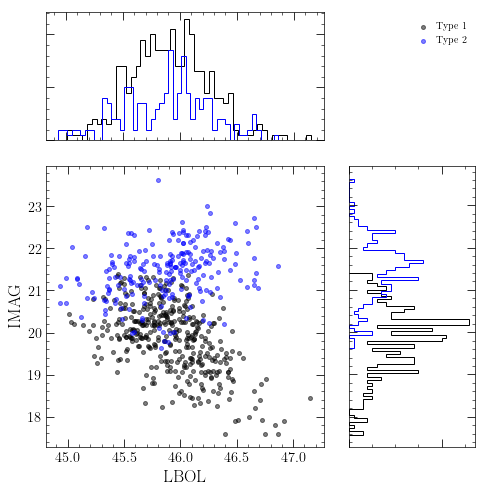

In [12]:
#recreating (kind of im using I not R) figure 1 in 2011 paper
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(type1['LBOL'],type1['IMAG'], color = 'black', label = 'Type 1', alpha = 0.5)
ax.scatter(type2['LBOL'],type2['IMAG'], color = 'blue', label = 'Type 2', alpha = 0.5)
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'IMAG')
ax.set_xlabel(r'LBOL')
#ax.set_xlim(0, 3)
#ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(type1['LBOL'],bins=50, histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(type2['LBOL'],bins=50, histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_xlim(0, 3)
#ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(type1['IMAG'],bins=50, orientation='horizontal', histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(type2['IMAG'],bins=50, orientation='horizontal', histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylim(38,50)
#ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

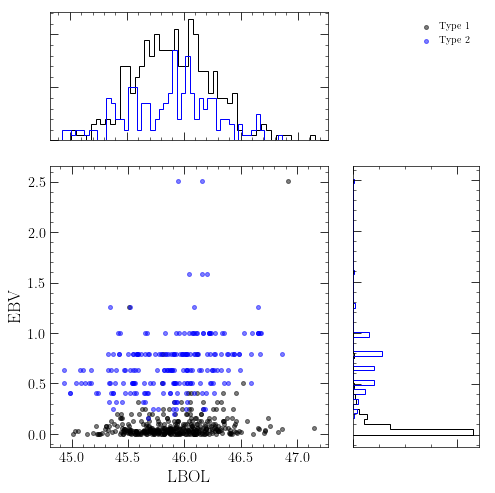

In [13]:
#recreating (kind of im using I not R) figure 1 in 2011 paper
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(type1['LBOL'],type1['EBV'], color = 'black', label = 'Type 1', alpha = 0.5)
ax.scatter(type2['LBOL'],type2['EBV'], color = 'blue', label = 'Type 2', alpha = 0.5)
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'EBV')
ax.set_xlabel(r'LBOL')
#ax.set_xlim(0, 3)
#ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(type1['LBOL'],bins=50, histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(type2['LBOL'],bins=50, histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_xlim(0, 3)
#ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(type1['EBV'],bins=50, orientation='horizontal', histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(type2['EBV'],bins=50, orientation='horizontal', histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylim(38,50)
#ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



(array([1., 0., 0., ..., 0., 0., 2.]),
 array([0.16    , 0.160235, 0.16047 , ..., 2.50953 , 2.509765, 2.51    ],
       dtype=float32),
 <a list of 1 Patch objects>)

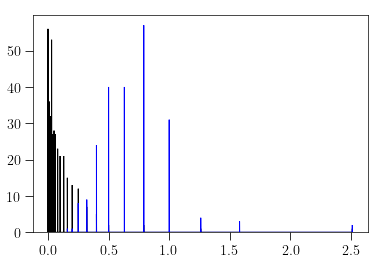

In [14]:
plt.hist(type1['EBV'], bins=10000, histtype='step', color='black', density=False, lw=1)
plt.hist(type2['EBV'], bins=10000, histtype='step', color='blue', density=False, lw=1)
#plt.xlim(0.01,0.5)

In [15]:
EBV0 = data[data['EBV']!=0.0]
type1 = EBV0[EBV0['TYPE']==1]
type2 = EBV0[EBV0['TYPE']==2]


In [16]:
type1

RAdeg,DEdeg,Imag,S,zspec,N,zG,chi2G,LEll,LSbc,LIrr,zGA,chi2GA,LAGNp,LELLp,LSbcp,LIrrp,F,EBV,LAGNerg,logF,I,index,LSbcerg,LEllerg,LIrrerg,Lg,LGlog,LSbcergp,LEllergp,LIrrergp,Lgp,LGlogp,RA,DEC,Z,IMAG,TYPE,LBOL,Separation,AV
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,
float64,float64,float32,float32,float32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64
216.49839,32.47729,21.11,0.71,1.75,12/0,1.89,13.28,0.0,1.505,1.641,1.71,1.59,1.981,0.0,1.541,-1.838,30.33,0.1,45.561,1.4818724103106635,19.03,7812.0,45.085,43.58,45.221,2.8795986510165264e+45,45.45933196144145,45.120999999999995,43.58,41.742,1.3218477116258411e+45,45.12118142352311,216.49852,32.477431,1.7523000240325928,21.19,1,45.9181019295332,0.6430629455451671,0.3200000047683716
217.54525,32.54919,18.53,0.91,1.03,14/0,0.01,82.58,0.0,1.515,1.531,0.31,12.93,2.085,-1.173,0.0,1.75,27.92,0.25,45.665,1.4459154139511234,19.37,11670.0,45.095,43.58,45.111,2.5357338853849075e+45,45.40410367422031,43.58,42.407,45.33,2.140514790804885e+45,45.330518233124664,217.54522,32.549159,1.0250999927520752,18.56,1,45.98367407471405,0.14402150290169774,0.8
217.79479,32.6436,20.21,0.98,1.43,13/0,1.87,62.11,0.0,1.614,1.877,1.47,6.53,2.3,1.327,0.0,0.37,39.31,0.1,45.879999999999995,1.5945030438200891,19.7,16438.0,45.193999999999996,43.58,45.457,4.4273256125475235e+45,45.646141463820356,43.58,44.907,43.949999999999996,8.963601240622053e+44,44.952482528044925,217.79464,32.643638,1.4297499656677246,20.21,1,46.10275895923794,0.4748355104465783,0.3200000047683716
217.7623,32.65776,17.8,1.0,1.65,14/0,0.01,101.07,0.0,2.167,2.388,1.39,8.06,3.07,0.0,0.0,2.339,52.96,0.02,46.65,1.7239479764316434,19.74,17145.0,45.747,43.58,45.967999999999996,1.4874365815167592e+46,46.17243845817574,43.58,43.58,45.919,8.298507675144166e+45,45.919,217.76225,32.657764,1.6472200155258179,17.8,1,46.83575332769093,0.1522262087145012,0.06399999856948853
216.74472,32.66777,20.63,0.97,1.77,13/0,2.64,24.51,0.0,1.604,1.927,1.8,6.45,2.399,1.309,0.0,0.0,13.61,0.16,45.979,1.1338581252033346,19.77,17679.0,45.184,43.58,45.507,4.741226596878366e+45,45.67589071199945,43.58,44.888999999999996,43.58,7.744617978025113e+44,44.888999999999996,216.74449,32.667687,1.77375,20.64,1,46.10102864963899,0.7583681013526183,0.5119999885559082
216.43225,32.68456,20.67,0.9,1.27,13/0,2.28,46.87,0.0,1.462,1.764,0.23,3.16,1.752,0.0,0.904,0.0,63.33,0.06,45.332,1.8016094880273188,19.82,18636.0,45.042,43.58,45.344,3.3095440425603246e+45,45.519768164941866,44.484,43.58,43.58,3.0478949896279954e+44,44.484,216.4321,32.684339,1.266510009765625,20.7,1,45.81057598059604,0.9162669096377796,0.1919999957084656
216.87591,32.68521,18.43,0.92,1.79,14/0,0.01,161.68,0.0,1.838,2.143,1.44,9.43,3.124,0.989,0.0,0.0,73.66,0.06,46.704,1.8672317145188941,19.82,18672.0,45.418,43.58,45.723,7.902635525970772e+45,45.897771952493464,43.58,44.568999999999996,43.58,3.706807217825722e+44,44.568999999999996,216.87571,32.68516,1.792769,18.45,1,47.15210622690538,0.6321565024749108,0.1919999957084656
216.57118,32.68826,20.17,0.98,1.09,14/0,1.79,66.88,0.0,1.779,1.237,0.49,7.39,1.942,0.919,0.0,0.948,37.23,0.79,45.522,1.5708930362183922,19.83,18840.0,45.358999999999995,43.58,44.817,2.9417440696783077e+45,45.468604886623574,43.58,44.498999999999995,44.528,6.527877709963271e+44,44.8147720099637,216.57107,32.688301,1.086343,20.17,1,45.81318558283965,0.3645033142043569,2.528000068664551


(0, 60)

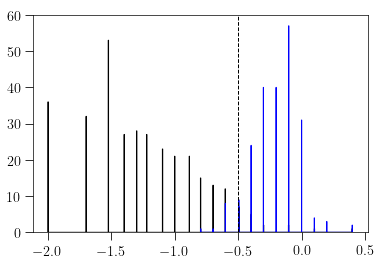

In [17]:
plt.hist(np.log10(type1['EBV']), bins=1000, histtype='step', color='black', density=False, lw=1)
plt.hist(np.log10(type2['EBV']), bins=1000, histtype='step', color='blue', density=False, lw=1)
plt.vlines(-0.5,0,60, linestyle = 'dashed')
plt.ylim(0,60)

(0, 60)

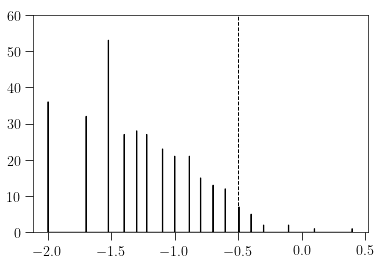

In [18]:
plt.hist(np.log10(type1['EBV']), bins=1000, histtype='step', color='black', density=False, lw=1)
#plt.hist(np.log10(type2['EBV']), bins=1000, histtype='step', color='blue', density=False, lw=1)
plt.vlines(-0.5,0,60, linestyle = 'dashed')
plt.ylim(0,60)

(0, 60)

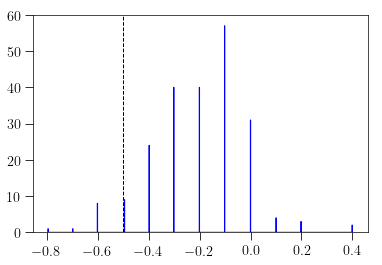

In [19]:
#plt.hist(np.log10(type1['EBV']), bins=1000, histtype='step', color='black', density=False, lw=1)
plt.hist(np.log10(type2['EBV']), bins=1000, histtype='step', color='blue', density=False, lw=1)
plt.vlines(-0.5,0,60, linestyle = 'dashed')
plt.ylim(0,60)

[]

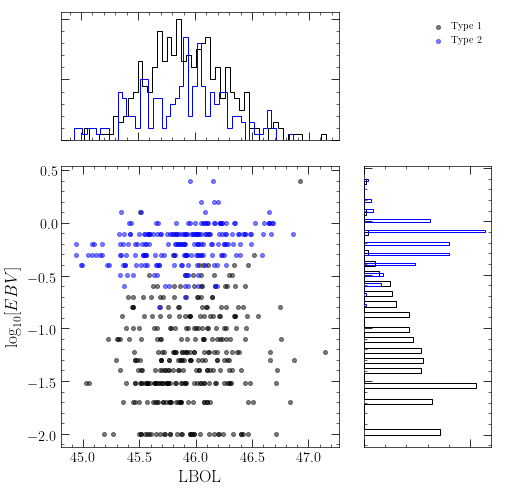

In [20]:
#recreating (kind of im using I not R) figure 1 in 2011 paper
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(type1['LBOL'],np.log10(type1['EBV']), color = 'black', label = 'Type 1', alpha = 0.5)
ax.scatter(type2['LBOL'],np.log10(type2['EBV']), color = 'blue', label = 'Type 2', alpha = 0.5)
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[EBV] $')
ax.set_xlabel(r'LBOL')
#ax.set_xlim(0, 3)
#ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(type1['LBOL'],bins=50, histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(type2['LBOL'],bins=50, histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_xlim(0, 3)
#ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(np.log10(type1['EBV']),bins=50, orientation='horizontal', histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(np.log10(type2['EBV']),bins=50, orientation='horizontal', histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylim(38,50)
#ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

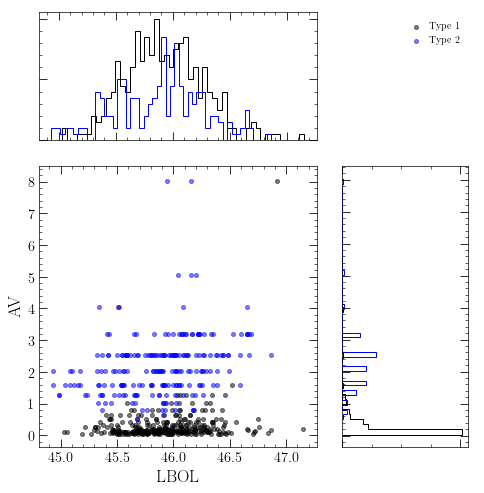

In [21]:
#recreating (kind of im using I not R) figure 1 in 2011 paper
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(type1['LBOL'],type1['AV'], color = 'black', label = 'Type 1', alpha = 0.5)
ax.scatter(type2['LBOL'],type2['AV'], color = 'blue', label = 'Type 2', alpha = 0.5)
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'AV')
ax.set_xlabel(r'LBOL')
#ax.set_xlim(0, 3)
#ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(type1['LBOL'],bins=50, histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(type2['LBOL'],bins=50, histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_xlim(0, 3)
#ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(type1['AV'],bins=50, orientation='horizontal', histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(type2['AV'],bins=50, orientation='horizontal', histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylim(38,50)
#ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



(array([1., 0., 0., ..., 0., 0., 2.]),
 array([0.51199999, 0.51275199, 0.51350399, ..., 8.03049597, 8.03124797,
        8.03199997]),
 <a list of 1 Patch objects>)

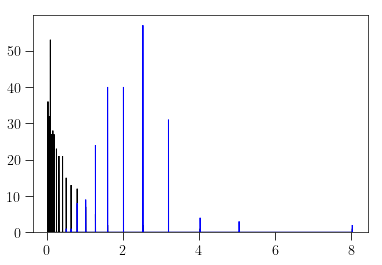

In [22]:
plt.hist(type1['AV'], bins=10000, histtype='step', color='black', density=False, lw=1)
plt.hist(type2['AV'], bins=10000, histtype='step', color='blue', density=False, lw=1)
#plt.xlim(0.01,0.5)

Text(0, 0.5, 'N')

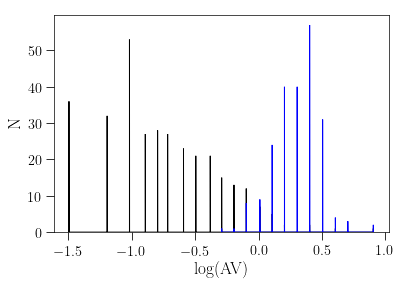

In [23]:
plt.hist(np.log10(type1['AV']), bins=10000, histtype='step', color='black', density=False, lw=1)
plt.hist(np.log10(type2['AV']), bins=10000, histtype='step', color='blue', density=False, lw=1)
plt.xlabel('log(AV)')
plt.ylabel('N')

[]

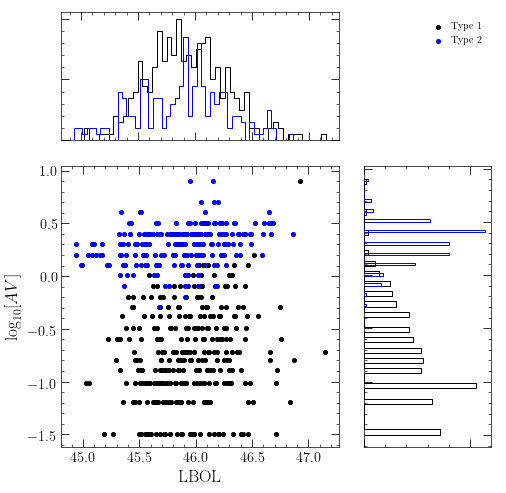

In [24]:
#recreating (kind of im using I not R) figure 1 in 2011 paper
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(type1['LBOL'],np.log10(type1['AV']), color = 'black', label = 'Type 1', alpha = 1)
ax.scatter(type2['LBOL'],np.log10(type2['AV']), color = 'blue', label = 'Type 2', alpha = 1)
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[AV] $')
ax.set_xlabel(r'LBOL')
#ax.set_xlim(0, 3)
#ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(type1['LBOL'],bins=50, histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(type2['LBOL'],bins=50, histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_xlim(0, 3)
#ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(np.log10(type1['AV']),bins=50, orientation='horizontal', histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(np.log10(type2['AV']),bins=50, orientation='horizontal', histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylim(38,50)
#ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



[]

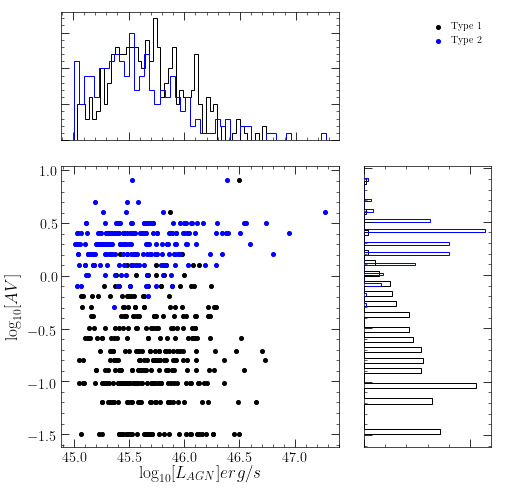

In [25]:
#recreating (kind of im using I not R) figure 1 in 2011 paper
fig = plt.figure(figsize=(24,8))
gs = GridSpec(nrows=3,ncols=9, figure=fig)


ax = fig.add_subplot(gs[1:, 0:2])
ax.scatter(type1['LAGNerg'],np.log10(type1['AV']), color = 'black', label = 'Type 1', alpha = 1)
ax.scatter(type2['LAGNerg'],np.log10(type2['AV']), color = 'blue', label = 'Type 2', alpha = 1)
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
ax.set_ylabel(r'$ \log_{10}[AV] $')
ax.set_xlabel(r'$ \log_{10}[L_{AGN}] erg/s $')
#ax.set_xlim(44, 3)
#ax.set_ylim(38,50)
handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
ax.legend(handles=handles, labels=labels)

ax = fig.add_subplot(gs[0, 0:2])
ax.hist(type1['LAGNerg'],bins=50, histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(type2['LAGNerg'],bins=50, histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_xlim(0, 3)
#ax.set_ylim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)

ax = fig.add_subplot(gs[1:, 2])
ax.hist(np.log10(type1['AV']),bins=50, orientation='horizontal', histtype ='step', color = 'black', density=False, lw=1, label="x", log=False )
ax.hist(np.log10(type2['AV']),bins=50, orientation='horizontal', histtype ='step', color = 'blue', density=False, lw=1, label="x", log=False )
#ax.hlines(45, -20, 10**4, colors='firebrick', linestyles='dashed', label='L = $10^{45}$ erg/s')
ax.minorticks_on()
ax.tick_params(which='both', direction='in', top="on", right='on')
#ax.set_ylim(38,50)
#ax.set_xlim(10**0,10**4)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
#ax.legend(frameon=False, loc=2)



In [26]:
from scipy.stats import anderson_ksamp
KS  = ks_2samp(type1['LAGNerg'],type2['LAGNerg'] )
AD = anderson_ksamp([type1['LAGNerg'],type2['LAGNerg']])

from scipy import special
sigma = special.erfcinv(AD[2])*np.sqrt(2)
print (AD)
print (KS)
print ("Sigma:", sigma)

Anderson_ksampResult(statistic=9.59349575773826, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.00016547790300182753)
Ks_2sampResult(statistic=0.16201896263245952, pvalue=0.001729563478534128)
Sigma: 3.766611945895405


In [27]:
from scipy.stats import anderson_ksamp
KS  = ks_2samp(np.log10(type1['AV']),np.log10(type2['AV']) )
AD = anderson_ksamp([np.log10(type1['AV']),np.log10(type2['AV'])])

from scipy import special
sigma = special.erfcinv(AD[2])*np.sqrt(2)
print (AD)
print (KS)
print (sigma)

Anderson_ksampResult(statistic=272.02044213722985, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=inf)
Ks_2sampResult(statistic=0.8993307306190742, pvalue=8.389900052493441e-95)
-inf


In [28]:
type2['LAGNerg']

45.216
45.289
45.478
46.342999999999996
45.013999999999996
46.015
45.656
45.803
45.411
45.439
45.187


In [29]:
print (len(type1))
print (len(type2))
t1m1 = type1[np.log10(type1['AV'])>=0]
t2l1 = type2[np.log10(type2['AV'])<=0]
t1l1 = type1[np.log10(type1['AV'])<=0]
t2m1 = type2[np.log10(type2['AV'])>=0]
print (len(t1m1))
print (len(t2l1))
print (len(t1l1))
print (len(t2m1))
t1m5 = type1[np.log10(type1['AV'])>=-0.5]
t2l5 = type2[np.log10(type2['AV'])<=-0.5]
t1l5 = type1[np.log10(type1['AV'])<=-0.5]
t2m5 = type2[np.log10(type2['AV'])>=-0.5]
print (len(t1m5))
print (len(t2l5))
print (len(t1l5))
print (len(t2m5))

326
220
18
10
308
210
100
0
226
220


In [30]:
print (len(t1m5)/len(type1))
print (len(t1l5)/len(type1))
print (len(t1m1)/len(type1))
print (len(t1l1)/len(type1))

0.3067484662576687
0.6932515337423313
0.05521472392638037
0.9447852760736196


In [31]:
print (len(t2m5)/len(type2))
print (len(t2l5)/len(type2))
print (len(t2m1)/len(type2))
print (len(t2l1)/len(type2))

1.0
0.0
0.9545454545454546
0.045454545454545456


In [32]:
#conclusion from the more detailed analysis is that in AV the percentages for type 1 and type 2 at the boundary of av 1 is 94 and 95 % so this is a good choice.

In [33]:
t1m7 = type1[np.log10(type1['AV'])>=-0.1]
t2l7 = type2[np.log10(type2['AV'])<=-0.1]
t1l7 = type1[np.log10(type1['AV'])<=-0.1]
t2m7 = type2[np.log10(type2['AV'])>=-0.1]
print (len(t1m7))
print (len(t2l7))
print (len(t1l7))
print (len(t2m7))
print (len(t1m7)/len(type1))
print (len(t1l7)/len(type1))
print (len(t2m7)/len(type2))
print (len(t2l7)/len(type2))

30
2
296
218
0.09202453987730061
0.9079754601226994
0.990909090909091
0.00909090909090909


In [34]:
t1m7 = type1[np.log10(type1['AV'])>=0]
t2l7 = type2[np.log10(type2['AV'])<=0]
t1l7 = type1[np.log10(type1['AV'])<=0]
t2m7 = type2[np.log10(type2['AV'])>=0]
print (len(t1m7))
print (len(t2l7))
print (len(t1l7))
print (len(t2m7))
print (len(t1m7)/len(type1))
print (len(t1l7)/len(type1))
print (len(t2m7)/len(type2))
print (len(t2l7)/len(type2))

18
10
308
210
0.05521472392638037
0.9447852760736196
0.9545454545454546
0.045454545454545456


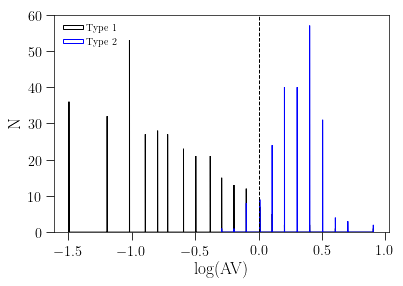

In [35]:
plt.hist(np.log10(type1['AV']), bins=10000, histtype='step', color='black', density=False, lw=1, label = 'Type 1')
plt.hist(np.log10(type2['AV']), bins=10000, histtype='step', color='blue', density=False, lw=1, label = 'Type 2')
plt.vlines(0,0,60, linestyle = 'dashed')
plt.xlabel('log(AV)')
plt.ylabel('N')
plt.ylim(0,60)
plt.legend()



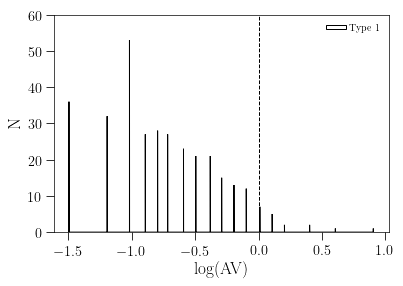

In [36]:
plt.hist(np.log10(type1['AV']), bins=10000, histtype='step', color='black', density=False, lw=1, label = 'Type 1')
#plt.hist(np.log10(type2['AV']), bins=10000, histtype='step', color='blue', density=False, lw=1, label = 'Type 2')
plt.vlines(0,0,60, linestyle = 'dashed')
plt.xlabel('log(AV)')
plt.ylabel('N')
plt.ylim(0,60)
plt.legend()

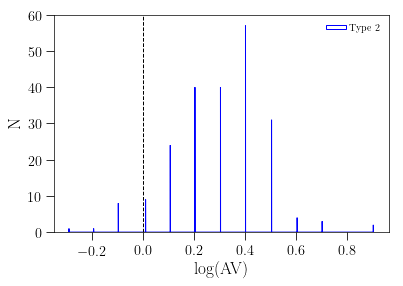

In [37]:
#plt.hist(np.log10(type1['AV']), bins=10000, histtype='step', color='black', density=False, lw=1, label = 'Type 1')
plt.hist(np.log10(type2['AV']), bins=10000, histtype='step', color='blue', density=False, lw=1, label = 'Type 2')
plt.vlines(0,0,60, linestyle = 'dashed')
plt.xlabel('log(AV)')
plt.ylabel('N')
plt.ylim(0,60)
plt.legend()

In [38]:
t1m7 = type1[np.log10(type1['AV'])>=0.1]

In [39]:
x2 = np.log10(type2['AV'])
#x2 = list(set(x2))
T2=[]
for i in x2:
    T2.append(len(np.array(type2[np.log10(type2['AV'])<=i]['AV'])))
P2=[]
for i in T2:
    P2.append(i/len(type2))

In [40]:
x1 = np.log10(type1['AV'])
x1 = list(set(x1))
T1=[]
for i in x1:
    T1.append(len(np.array(type1[np.log10(type1['AV'])>=i]['AV'])))

#len(np.array(type1[np.log10(type1['AV'])>=0]['AV']))

P1=[]
for i in T1:
    P1.append(i/len(type1))

In [41]:
len(np.array(type2[np.log10(type2['AV'])>=-0.01]['AV']))

210

In [42]:
210/len(type2)

0.9545454545454546

In [43]:
P1.sort()
x1.sort()
P1.reverse()


In [44]:
P2.sort()
x2.sort()

(0, 1)

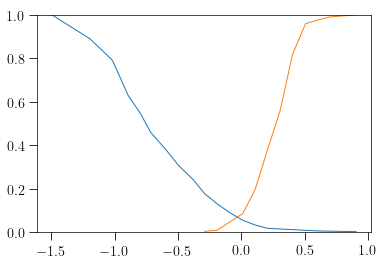

In [45]:
plt.plot(x1,P1)
plt.plot(x2,P2)
#plt.scatter(x1,P1)
#plt.scatter(x2,P2)
plt.ylim(0,1)

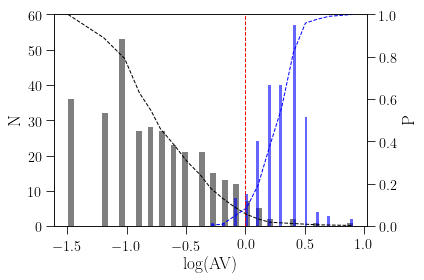

In [46]:

fig, ax1 = plt.subplots()


ax1.set_xlabel('log(AV)')
ax1.set_ylabel('N')
ax1.hist(np.log10(type1['AV']), bins=50, histtype='bar', color='black', density=False, lw=1, label = 'Type 1', alpha = 0.5)
ax1.hist(np.log10(type2['AV']), bins=50, histtype='bar', color='blue', density=False, lw=1, label = 'Type 2', alpha = 0.6)
ax1.vlines(0,0,60, linestyle = 'dashed', color='red')
ax1.tick_params(axis='y')
ax1.set_ylim(0,60)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('P')  # we already handled the x-label with ax1
ax2.plot(x1,P1,color='black', linestyle = '--')
ax2.plot(x2,P2,color='blue', linestyle = '--')
ax2.tick_params(axis='y')
ax2.set_ylim(0,1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


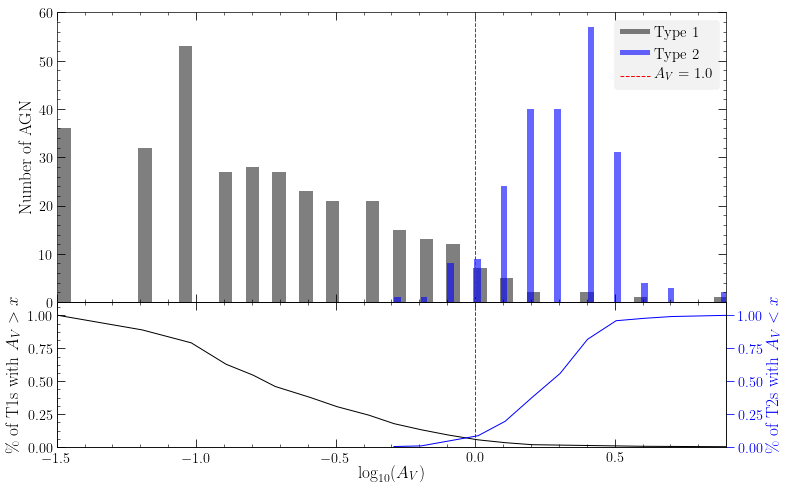

In [49]:
fig = plt.figure(figsize=(12,8))
gs = GridSpec(nrows=2,ncols=1, figure=fig, height_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0])

ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top="on", right='on')
ax1.hist(np.log10(type1['AV']), bins=50, histtype='bar', color='black', density=False, lw=1, label = 'Type 1', alpha = 0.5)
ax1.hist(np.log10(type2['AV']), bins=50, histtype='bar', color='blue', density=False, lw=1, label = 'Type 2', alpha = 0.6)
ax1.vlines(0,0,60, linestyle = 'dashed', color='red', label = r'$A_V=1.0$')
ax1.set_xlim(-1.5,0.9)
ax1.set_ylabel('Number of AGN')
ax1.set_ylim(0, 60)
ax1.legend(fontsize='15',frameon = True, framealpha=0.1, facecolor = 'gray')



ax2 = fig.add_subplot(gs[1], sharex = ax1)
ax2.minorticks_on()
plt.setp(ax1.get_xticklabels(), visible=False)
ax2.tick_params(which='both', direction='in', top="on", right='on', labelcolor = 'black')
ax2.plot(x1,P1,color='black', linestyle = '-')
ax2.vlines(0,3,0, linestyle = 'dashed', color='red')
ax2.set_xlabel(r'$ \log_{10}(A_V)$')
ax2.set_ylabel(r'$\%$ of T1s with $A_V>x$', color ='black')
ax2.set_ylim(0, 1.1)
ax2.set_xlim(-1.5,0.9)

plt.subplots_adjust(hspace=.0)



ax3 = ax2.twinx()  # instantiate a second axes that shares the same y-axis
ax3.set_ylabel(r'$\%$ of T2s with $A_V<x$', color ='blue') 
ax3.plot(x2,P2,color='blue', linestyle = '-')
ax3.tick_params(axis='y', colors = 'blue')
ax3.set_ylim(0, 1.1)
ax3.set_xlim(-1.5,0.9)

plt.savefig('Figure6.png')

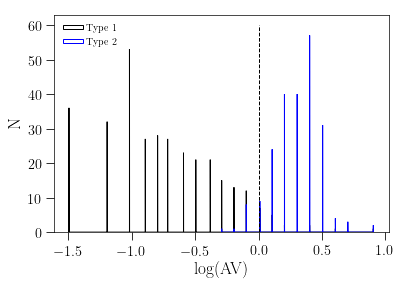

In [49]:
plt.hist(np.log10(type1['AV']), bins=10000, histtype='step', color='black', density = False, lw=1, label = 'Type 1')
plt.hist(np.log10(type2['AV']), bins=10000, histtype='step', color='blue', density = False, lw=1, label = 'Type 2')
plt.vlines(0,0,60, linestyle = 'dashed')
plt.xlabel('log(AV)')
plt.ylabel('N')
#plt.ylim(0,60)
plt.legend()



In [50]:
np.max(np.log10(type2['AV']))

0.9048236981508425

In [51]:
popt1

NameError: name 'popt1' is not defined

In [ ]:
popt2

In [ ]:
a = popt1[0]-popt2[0]
b = popt1[1]-popt2[1]
c = popt1[2]-popt2[2]


x = (-b-np.sqrt(b**2-4*a*c))/(2*a)
print (x)

#this is basically 0 and so works 

In [ ]:
data = Table.read('T1T2LmatchL0cut10.fits', format = 'fits' )

In [ ]:
data

In [ ]:



plt.hist(data['col22_2'], bins = 50)


In [ ]:
plt.hist(data['col22_1'], bins = 50)